[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://bit.ly/open-data-03-franchise-input)

## 소상공인시장진흥공단 상가업소정보로 프랜차이즈 입점분석

* 배스킨라빈스와 던킨도너츠는 근처에 입지한 것을 종종 볼 수 있었어요.
* 또, 파리바게뜨와 뚜레주르는 주변에서 많이 볼 수 있는 프랜차이즈 중 하나에요. 
* 이런 프랜차이즈 매장이 얼마나 모여 있는지 혹은 흩어져 있는지 지도에 직접 표시를 해보면서 대용량 데이터에서 원하는 특정 데이터를 추출해 보는 실습을 해봅니다.
* 추출한 데이터를 전처리하고 가공해서 원하는 형태로 시각화를 하거나 지도에 표현합니다.
* Python, Pandas, Numpy, Seaborn, Matplotlib, folium 을 통해 다양한 방법으로 표현하면서 파이썬의 여러 도구들에 익숙해 지는 것을 목표로 합니다.

### 다루는 내용
* 데이터 요약하기
* 공공데이터를 활용해 텍스트 데이터 정제하고 원하는 정보 찾아내기
* 문자열에서 원하는 텍스트 추출하기
* 문자열을 활용한 다양한 분석 방법과 위치 정보 사용하기
* folium을 통한 위경도 데이터 시각화 이해하기
* folium을 통해 지도에 분석한 내용을 표현하기 - CircleMarker와 MarkerCluster 그리기


### 데이터셋
* 공공데이터 포털 : https://www.data.go.kr/dataset/15012005/fileData.do
* 영상에 사용한 데이터셋 : http://bit.ly/open-data-set-folder (공공데이터포털에서 다운로드 받은 파일이 있습니다. 어떤 파일을 다운로드 받아야 될지 모르겠다면 여기에 있는 파일을 사용해 주세요.)

## 필요한 라이브러리 불러오기

In [1]:
# pandas, numpy, seaborn을 불러옵니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 구버전의 주피터 노트북에서 그래프가 보이는 설정
%matplotlib inline

## 시각화를 위한 한글 폰트 설정하기

In [ ]:
# 폰트 설정이 잘 안 된다면 해당 셀의 마지막 줄 주석을 풀고 실행해 보세요.
# colab 사용시에도 아래 함수를 활용해 보세요.
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

# plt.rc("font", family=get_font_family())

In [2]:
# 폰트가 선명하게 보이도록 설정
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [8]:
# 한글폰트와 마이너스 폰트 설정 확인
plt.rc("font", family = "Malgun Gothic")

## Google Colab 을 위한 코드
### Colab 에서 실행을 위한 코드

* 아래의 코드는 google colaboratory 에서 실행을 위한 코드로 로컬 아나콘다에서는 주석처리합니다.
* google colaboratory 에서는 주석을 풀고 폰트 설정과 csv 파일을 불러옵니다.

In [ ]:
# # 나눔고딕 설치
# !apt -qq -y install fonts-nanum > /dev/null

# import matplotlib.font_manager as fm

# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
# fm._rebuild()

# # 그래프에 retina display 적용
# %config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

### Colab 용 GoogleAuth 인증 
* 구글 드라이브에 있는 파일을 가져오기 위해 사용합니다.

In [ ]:
# # 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # PyDrive client 인증
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# # 공유 가능한 링크로 파일 가져오기
# url = 'https://drive.google.com/open?id=1e91PH_KRFxNXUsx8Hi-Q2vPiorCDsOP4'
# id = url.split('=')[1]
# print(id)
# downloaded = drive.CreateFile({'id':id}) 
# # data 폴더에 파일을 관리하며, 폴더가 없다면 만들어서 파일을 관리하도록 한다.
# %mkdir data
# downloaded.GetContentFile('data/상가업소정보_201912_01.csv')  

## 데이터 불러오기
* 공공데이터 포털 : https://www.data.go.kr/dataset/15012005/fileData.do
* 공공데이터 포털에서 소상공인시장진흥공단 상가업소정보를 다운로드 받아 사용했습니다
* 영상에 사용한 데이터셋 : http://bit.ly/open-data-set-folder (공공데이터포털에서 다운로드 받은 파일이 있습니다. 어떤 파일을 다운로드 받아야 될지 모르겠다면 여기에 있는 파일을 사용해 주세요.)

In [11]:
# 파일을 불러와 df 라는 변수에 담습니다.
df = pd.read_csv("./상가업소정보_201912_01.csv", sep ='|')

### 데이터 크기 보기

In [12]:
# shape 를 통해 불러온 csv 파일의 크기를 확인합니다.
df.shape

(573680, 39)

### info 보기

In [13]:
# info 를 사용하면 데이터의 전체적인 정보를 볼 수 있습니다.
# 데이터의 사이즈, 타입, 메모리 사용량 등을 볼 수 있습니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573680 entries, 0 to 573679
Data columns (total 39 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   상가업소번호     573680 non-null  int64  
 1   상호명        573679 non-null  object 
 2   지점명        76674 non-null   object 
 3   상권업종대분류코드  573680 non-null  object 
 4   상권업종대분류명   573680 non-null  object 
 5   상권업종중분류코드  573680 non-null  object 
 6   상권업종중분류명   573680 non-null  object 
 7   상권업종소분류코드  573680 non-null  object 
 8   상권업종소분류명   573680 non-null  object 
 9   표준산업분류코드   539290 non-null  object 
 10  표준산업분류명    539290 non-null  object 
 11  시도코드       573680 non-null  int64  
 12  시도명        573680 non-null  object 
 13  시군구코드      573680 non-null  int64  
 14  시군구명       573680 non-null  object 
 15  행정동코드      573680 non-null  int64  
 16  행정동명       573680 non-null  object 
 17  법정동코드      573680 non-null  int64  
 18  법정동명       573680 non-null  object 
 19  지번코드       573680 non-n

### 결측치 보기

<AxesSubplot:>

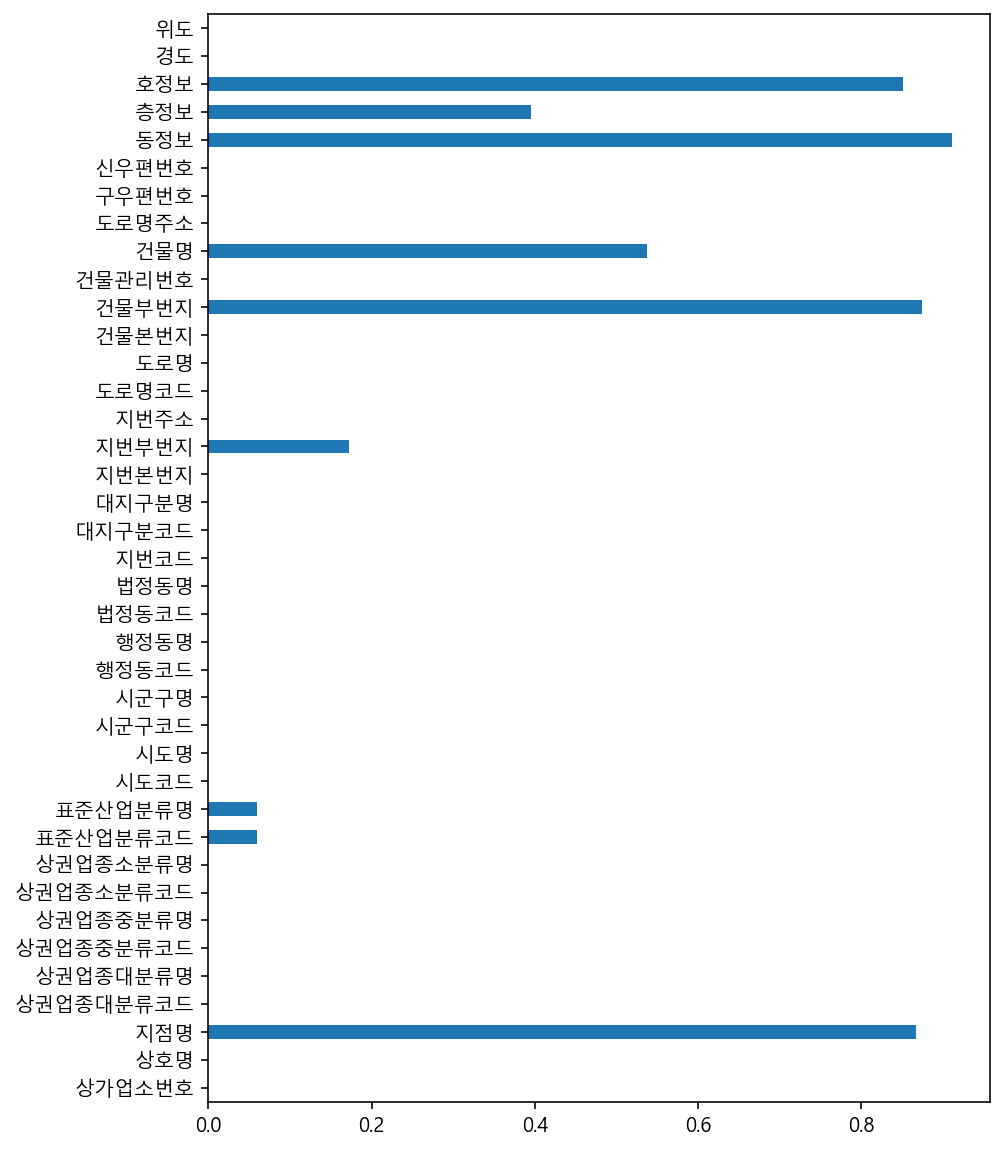

In [20]:
# isnull() 을 사용하면 데이터의 결측치를 볼 수 있습니다.
# 결측치는 True로 값이 있다면 False로 표시되는데 True 는 1과 같기 때문에 
# True 값을 sum()을 사용해서 더하게 되면 합계를 볼 수 있습니다.
# mean()을 사용하면 결측치의 비율을 볼 수 있습니다.

df.isnull().mean().plot.barh(figsize = (7, 10))

### 사용하지 않는 컬럼 제거하기

In [21]:
# drop을 하는 방법도 있지만 사용할 컬럼만 따로 모아서 보는 방법도 있습니다.
# 여기에서는 사용할 컬럼만 따로 모아서 사용합니다.
columns = ['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', 
           '시도명', '시군구명', '행정동명', '법정동명', '도로명주소', 
           '경도', '위도']

df = df[columns].copy()
df.shape

(573680, 11)

In [23]:
# 제거 후 메모리 사용량 보기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573680 entries, 0 to 573679
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   상호명       573679 non-null  object 
 1   상권업종대분류명  573680 non-null  object 
 2   상권업종중분류명  573680 non-null  object 
 3   상권업종소분류명  573680 non-null  object 
 4   시도명       573680 non-null  object 
 5   시군구명      573680 non-null  object 
 6   행정동명      573680 non-null  object 
 7   법정동명      573680 non-null  object 
 8   도로명주소     573680 non-null  object 
 9   경도        573680 non-null  float64
 10  위도        573680 non-null  float64
dtypes: float64(2), object(9)
memory usage: 48.1+ MB


## 색인으로 서브셋 가져오기
### 서울만 따로 보기

In [24]:
# 시도명이 서울로 시작하는 데이터만 봅니다.
# 또, df_seoul 이라는 변수에 결과를 저장합니다.
# 새로운 변수에 데이터프레임을 할당할 때 copy()를 사용하는 것을 권장합니다.

df_seoul = df[df['시도명']=='서울특별시'].copy()
df_seoul

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,도로명주소,경도,위도
0,와라와라호프,음식,유흥주점,호프/맥주,서울특별시,강남구,대치1동,대치동,서울특별시 강남구 남부순환로 2933,127.061026,37.493922
1,커피빈코리아선릉로93길점,음식,커피점/카페,커피전문점/카페/다방,서울특별시,강남구,역삼1동,역삼동,서울특별시 강남구 선릉로93길 6,127.047883,37.505675
2,프로포즈,음식,유흥주점,호프/맥주,서울특별시,금천구,독산3동,독산동,서울특별시 금천구 가산로 34-6,126.899220,37.471711
4,가락사우나내스낵,생활서비스,대중목욕탕/휴게,사우나/증기탕/온천,서울특별시,송파구,석촌동,석촌동,서울특별시 송파구 가락로 71,127.104071,37.500249
5,초밥왕,음식,일식/수산물,음식점-초밥전문,서울특별시,송파구,잠실6동,신천동,서울특별시 송파구 올림픽로 293-19,127.102490,37.515149
...,...,...,...,...,...,...,...,...,...,...,...
573675,비파티세리공덕,음식,한식,한식/백반/한정식,서울특별시,마포구,공덕동,공덕동,서울특별시 마포구 마포대로14길 4,126.955059,37.548618
573676,앤탑PC방,관광/여가/오락,PC/오락/당구/볼링등,인터넷PC방,서울특별시,성동구,성수2가3동,성수동2가,서울특별시 성동구 성수일로8길 37,127.054615,37.545853
573677,오즈아레나PC방,관광/여가/오락,PC/오락/당구/볼링등,인터넷PC방,서울특별시,강남구,논현1동,논현동,서울특별시 강남구 강남대로 492,127.024102,37.506202
573678,파인트리네일,생활서비스,이/미용/건강,발/네일케어,서울특별시,영등포구,여의동,여의도동,서울특별시 영등포구 국제금융로 10,126.924863,37.525172


In [27]:
# unique 를 사용하면 중복을 제거한 시군구명을 가져옵니다. 
# 그리고 shape로 갯수를 출력해 봅니다.

df_seoul['시군구명'].unique()

array(['강남구', '금천구', '송파구', '광진구', '강서구', '중구', '서초구', '성북구', '구로구',
       '영등포구', '서대문구', '동대문구', '노원구', '동작구', '성동구', '관악구', '강동구', '양천구',
       '종로구', '강북구', '은평구', '중랑구', '도봉구', '마포구', '용산구'], dtype=object)

In [28]:
# nunique 를 사용하면 중복을 제거한 시군구명의 갯수를 세어줍니다.
df_seoul['시군구명'].nunique()

25

## 파일로 저장하기
* 전처리한 파일을 저장해 두면 재사용을 할 수 있습니다.
* 재사용을 위해 파일로 저장합니다.

In [29]:
# "seoul_open_store.csv" 라는 이름으로 저장합니다.
df_seoul.to_csv("seoul_open_store.csv", index = False)

In [31]:
# 제대로 저장이 되었는지 같은 파일을 불러와서 확인합니다.
df_seoul = pd.read_csv("./seoul_open_store.csv")
df_seoul.head()

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,도로명주소,경도,위도
0,와라와라호프,음식,유흥주점,호프/맥주,서울특별시,강남구,대치1동,대치동,서울특별시 강남구 남부순환로 2933,127.061026,37.493922
1,커피빈코리아선릉로93길점,음식,커피점/카페,커피전문점/카페/다방,서울특별시,강남구,역삼1동,역삼동,서울특별시 강남구 선릉로93길 6,127.047883,37.505675
2,프로포즈,음식,유흥주점,호프/맥주,서울특별시,금천구,독산3동,독산동,서울특별시 금천구 가산로 34-6,126.899220,37.471711
3,가락사우나내스낵,생활서비스,대중목욕탕/휴게,사우나/증기탕/온천,서울특별시,송파구,석촌동,석촌동,서울특별시 송파구 가락로 71,127.104071,37.500249
4,초밥왕,음식,일식/수산물,음식점-초밥전문,서울특별시,송파구,잠실6동,신천동,서울특별시 송파구 올림픽로 293-19,127.102490,37.515149


## 배스킨라빈스, 던킨도너츠 위치 분석

### 특정 상호만 가져오기
* 여기에서는 배스킨라빈스와 던킨도너츠 상호를 가져와서 실습합니다.
* 위에서 pandas의 str.conatains를 활용해 봅니다.
* https://pandas.pydata.org/docs/user_guide/text.html#testing-for-strings-that-match-or-contain-a-pattern

* 상호명에서 브랜드명을 추출합니다.
* 대소문자가 섞여 있을 수도 있기 때문에 대소문자를 변환해 줍니다.
* 오타를 방지하기 위해 배스킨라빈스의 영문명은 baskinrobbins, 던킨도너츠는 dunkindonuts 입니다.

In [32]:
# 문자열의 소문자로 변경하는 메소드를 사용합니다.
# "상호명_소문자" 컬럼을 만듭니다.

df_seoul['상호명_소문자'] = df_seoul['상호명'].str.lower()

In [40]:
# baskinrobbins 를 "상호명_소문자" 컬럼으로 가져옵니다.
# 띄어쓰기 등의 다를 수 있기 때문에 앞글자 baskin 만 따서 가져오도록 합니다.
# '상호명_소문자'컬럼으로 '배스킨라빈스|baskin' 를 가져와 갯수를 세어봅니다.
# loc[행]
# loc[행, 열]
df_seoul["상호명_소문자"].str.extract("(배스킨라빈스|baskin)").value_counts()


배스킨라빈스    347
baskin      2
dtype: int64

In [43]:
df_seoul.loc[df_seoul["상호명_소문자"].str.contains("배스킨라빈스|베스킨라빈스|baskinrobbins"), "상호명_소문자"].shape

(466,)

In [44]:
# 상호명에서 던킨도너츠만 가져옵니다.
# 상호명은 소문자로 변경해 준 컬럼을 사용합니다.
# 던킨|dunkin 의 "상호명_소문자"로 갯수를 세어봅니다.

df_seoul.loc[df_seoul['상호명_소문자'].str.contains("던킨|dunkin"), "상호명_소문자"].shape


(191,)

In [56]:
# '상호명_소문자'컬럼으로  '배스킨|베스킨|baskin|던킨|dunkin'를 가져와 df_31 변수에 담습니다.
df_31 = df_seoul[df_seoul["상호명_소문자"].str.contains(
    '배스킨라빈스|베스킨라빈스|baskinrobbins|던킨|dunkin')].copy()
df_31.shape

(657, 12)

In [ ]:
# ~은 not을 의미합니다. 베스킨라빈스가 아닌 데이터를 찾을 때 사용하면 좋습니다.
# 아래 코드처럼 결측치를 던킨도너츠로 채워줘도 괜찮습니다.


In [59]:
# 'df_31에 담긴 상호명','브랜드명'으로 미리보기를 합니다.
# df_31.loc[~df_31["상호명_소문자"].str.contains("배스킨라빈스|베스킨라빈스|baskinrobbins"), 
#           "브랜드명"]
df_31.loc[df_31["상호명_소문자"].str.contains("배스킨라빈스|베스킨라빈스|baskinrobbins"), 
          "브랜드명"] = "배스킨라빈스"
df_31[["상호명","브랜드명"]].head()

,상호명,브랜드명
59,배스킨라빈스,배스킨라빈스
831,던킨도너츠,NaN
1313,던킨도너츠테크노마트점,NaN
1578,베스킨라빈스,배스킨라빈스
1652,던킨도너츠창동하나로,NaN


In [60]:
df_31['브랜드명'] = df_31['브랜드명'].fillna("던킨도너츠")
df_31["브랜드명"]

59        배스킨라빈스
831        던킨도너츠
1313       던킨도너츠
1578      배스킨라빈스
1652       던킨도너츠
           ...  
396623     던킨도너츠
398080     던킨도너츠
398781    배스킨라빈스
398782    배스킨라빈스
404507     던킨도너츠
Name: 브랜드명, Length: 657, dtype: object

In [61]:
# 데이터가 제대로 모아졌는지 확인합니다.
# "상권업종대분류명"을  value_counts 를 통해 빈도수를 계산합니다.

df_31['상권업종대분류명'].value_counts()

음식       655
생활서비스      1
소매         1
Name: 상권업종대분류명, dtype: int64

In [63]:
# "상권업종대분류명"컬럼에서 isin 기능을 사용해서 "소매", "생활서비스" 인 데이터만 가져옵니다.

df_31[df_31['상권업종대분류명'].isin(["소매","생활서비스"])]

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,도로명주소,경도,위도,상호명_소문자,브랜드명
252466,배스킨라빈스,소매,종합소매점,할인점,서울특별시,강남구,압구정동,신사동,서울특별시 강남구 압구정로 204,127.029381,37.527375,배스킨라빈스,배스킨라빈스
395221,baskinrobbins,생활서비스,광고/인쇄,인쇄종합,서울특별시,강남구,역삼1동,역삼동,서울특별시 강남구 강남대로 396,127.028289,37.498154,baskinrobbins,배스킨라빈스


In [65]:
# "상권업종대분류명"에서 "소매", "생활서비스"는 제외합니다.
df_31 = df_31[~df_31['상권업종대분류명'].isin(["소매","생활서비스"])].copy()
df_31.shape

(655, 13)

### 범주형 값으로 countplot 그리기

In [69]:
# value_counts 로 "브랜드명"의 빈도수를 구합니다.

brand_count = df_31['브랜드명'].value_counts()
brand_count

배스킨라빈스    464
던킨도너츠     191
Name: 브랜드명, dtype: int64

In [71]:
# normalize=True 로 빈도수의 비율을 구합니다.
df_31['브랜드명'].value_counts(normalize = True)

배스킨라빈스    0.708397
던킨도너츠     0.291603
Name: 브랜드명, dtype: float64

In [75]:
brand_count.index

Index(['배스킨라빈스', '던킨도너츠'], dtype='object')

In [78]:
brand_count

배스킨라빈스    464
던킨도너츠     191
Name: 브랜드명, dtype: int64

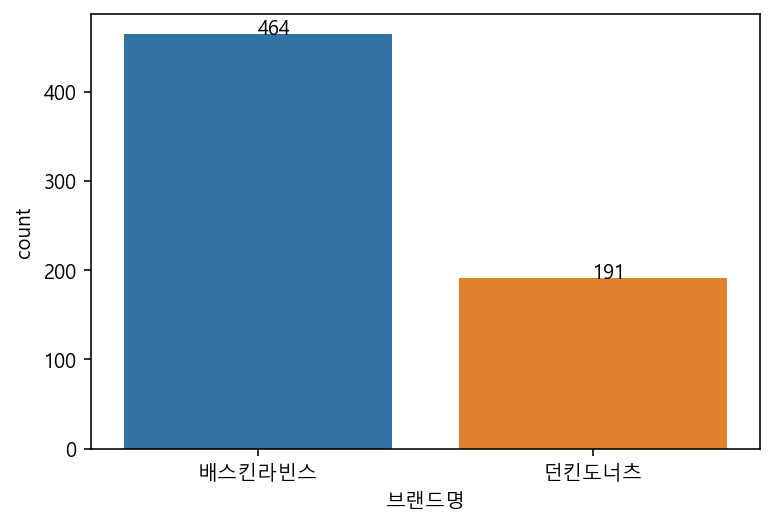

In [83]:
# countplot 을 그립니다.

g = sns.countplot(data = df_31 , x = '브랜드명')
for i, val in enumerate(brand_count.index):
    g.text(x=i, y=brand_count[i], s=brand_count[i])

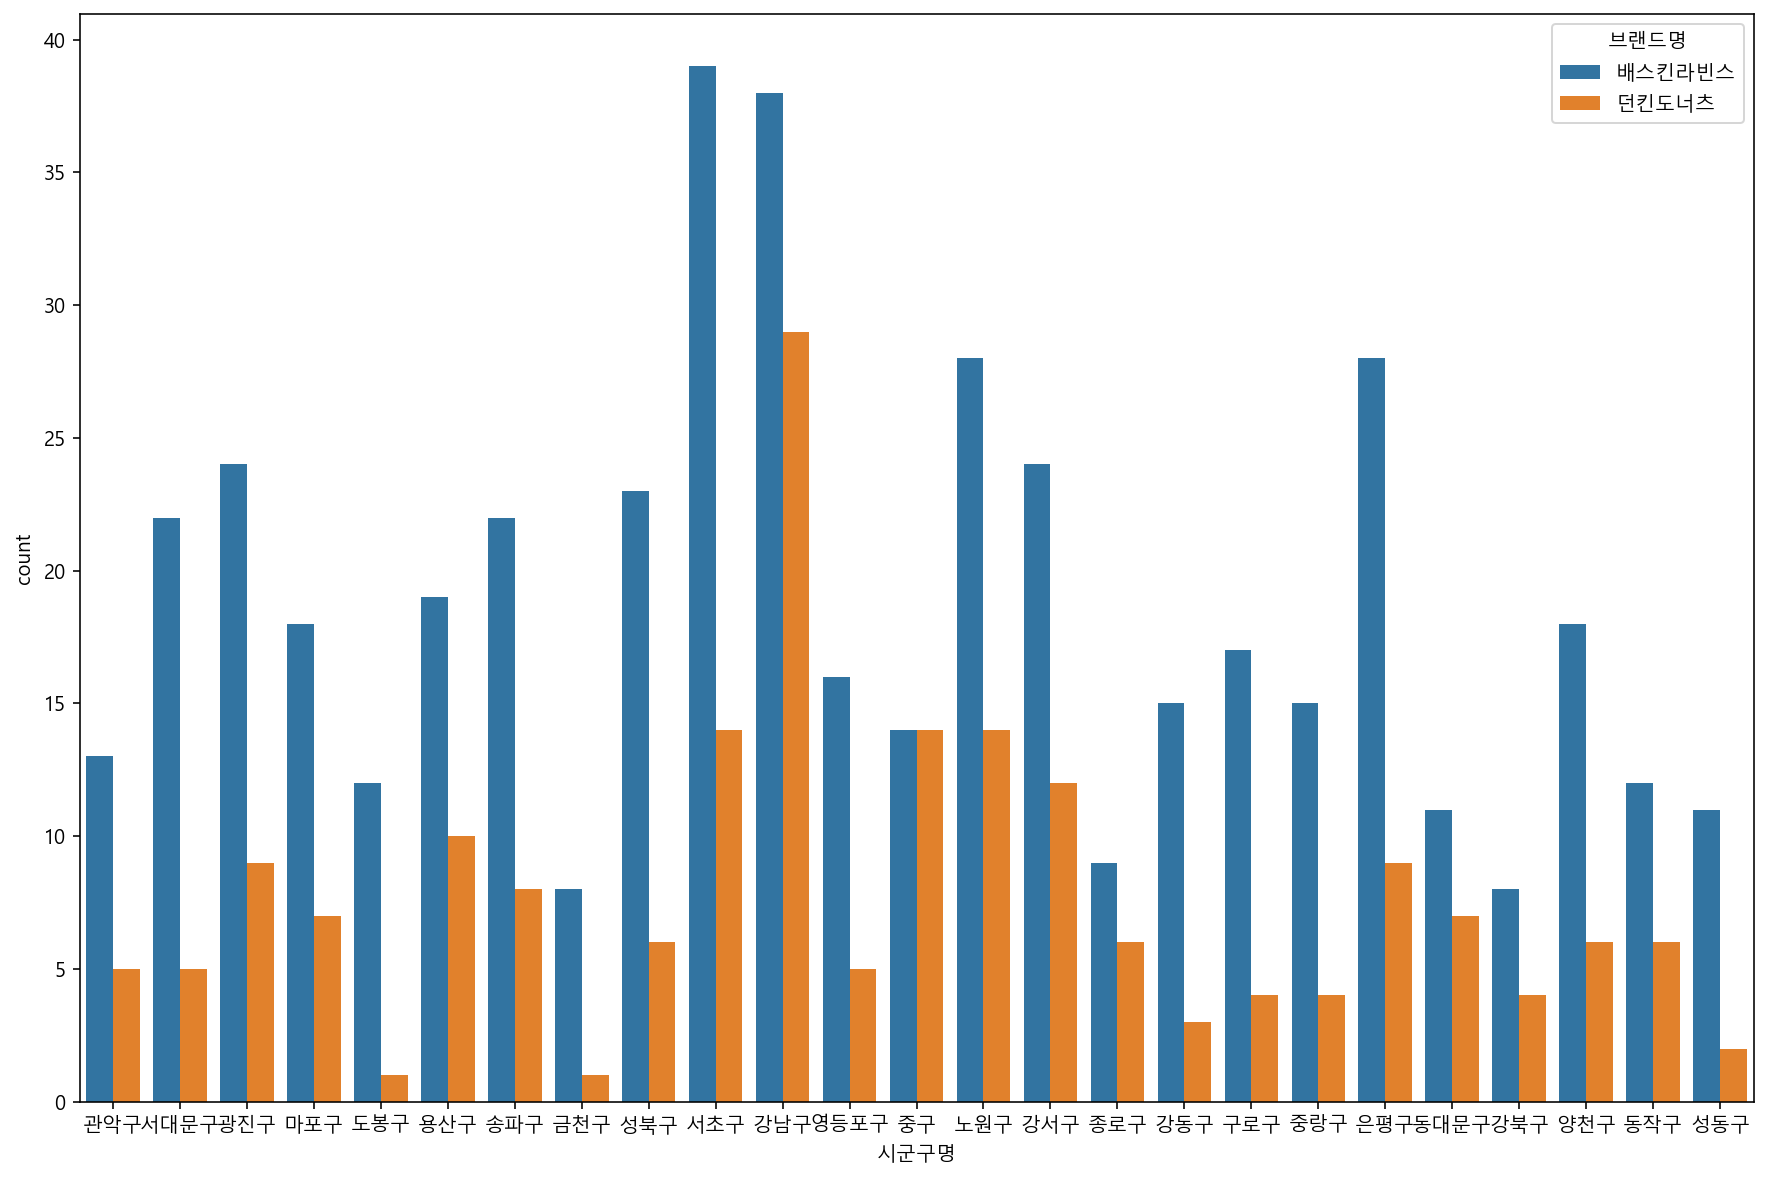

In [86]:
# 시군구명으로 빈도수를 세고 브랜드명으로 색상을 다르게 표현하는 countplot 을 그립니다.
plt.figure(figsize = ( 15, 10))
g = sns.countplot(data = df_31, x ='시군구명', hue='브랜드명')

### scatterplot 그리기

* https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#scatter-plot

In [ ]:
# Pandas 의 plot 으로 scatterplot 을 그립니다.


In [ ]:
# seaborn의 scatterplot 으로 hue에 브랜드명을 지정해서 시각화 합니다.


In [ ]:
# 위에서 그렸던 그래프를 jointplot 으로 kind="hex" 을 사용해 그려봅니다.


## Folium 으로 지도 활용하기
* 다음의 프롬프트 창을 열어 conda 명령어로 설치합니다.
<img src="https://i.imgur.com/x7pzfCP.jpg">
* <font color="red">주피터 노트북 상에서 설치가 되지 않으니</font> anaconda prompt 를 열어서 설치해 주세요.


* 윈도우
    * <font color="red">관리자 권한</font>으로 아나콘다를 설치하셨다면 다음의 방법으로 anaconda prompt 를 열어 주세요.
    <img src="https://i.imgur.com/GhoLwsd.png">
* 맥
    * terminal 프로그램을 열어 설치해 주세요. 


* 다음의 문서를 활용해서 지도를 표현합니다.
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Quickstart.ipynb
* Folium 사용예제 :
http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/

In [ ]:
# 아나콘다에서 folium 을 사용하기 위해서는 별도의 설치가 필요
# https://anaconda.org/conda-forge/folium
# conda install -c conda-forge folium 
# 지도 시각화를 위한 라이브러리


In [ ]:
# 지도의 중심을 지정하기 위해 위도와 경도의 평균을 구합니다. 


In [ ]:
# 샘플을 하나 추출해서 지도에 표시해 봅니다.



In [ ]:
# folium 사용법을 보고 일부 데이터를 출력해 봅니다.


In [ ]:
# html 파일로 저장하기
# tooltip 의 한글이 깨져보인다면 html 파일로 저장해서 보세요.


### 서울의 배스킨라빈스와 던킨도너츠 매장 분포
* 배스킨라빈스와 던킨도너츠 매장을 지도에 표현합니다.

In [ ]:
# 데이터프레임의 인덱스만 출력합니다.


### 기본 마커로 표현하기

In [ ]:
# icon=folium.Icon(color=icon_color) 로 아이콘 컬러를 변경합니다.


### MarkerCluster 로 표현하기
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/MarkerCluster.ipynb

In [ ]:
# icon=folium.Icon(color=icon_color) 로 아이콘 컬러를 변경합니다.


## 파리바게뜨와 뚜레주르 분석하기

### 데이터 색인으로 가져오기

In [ ]:
# str.contains 를 사용해서 뚜레(주|쥬)르|파리(바게|크라상) 으로 상호명을 찾습니다.
# df_bread 라는 데이터프레임에 담습니다.


### 가져온 데이터가 맞는지 확인하기

In [ ]:
# 잘못 가져온 데이터가 있는지 확인합니다.


In [ ]:
# 제과점과 상관 없을 것 같은 상점을 추출합니다.


In [ ]:
# "상권업종대분류명"이 "학문/교육"이 아닌 것만 가져옵니다.


In [ ]:
# 상호명의 unique 값을 봅니다.


In [ ]:
# 상호명이 '파스쿠찌|잠바주스'가 아닌 것만 가져오세요.



In [ ]:
# 브랜드명 컬럼을 만듭니다. "파리바게뜨" 에 해당되는 데이터에 대한 값을 채워줍니다.
# 파리크라상에 대한 처리를 따로 해주세요!
df_bread.loc[df_bread["상호명"].str.contains("파리크라상"), "브랜드명"] = "파리바게뜨"


In [ ]:
# 브랜드명 컬럼의 결측치는 "뚜레쥬르" 이기 때문에 fillna 를 사용해서 값을 채웁니다.


### 범주형 변수 빈도수 계산하기

In [ ]:
# 브랜드명의 빈도수를 봅니다.


In [ ]:
# countplot 으로 브랜드명을 그려봅니다.


In [ ]:
# 시군구별로 브랜드명의 빈도수 차이를 비교합니다.


In [ ]:
# scatterplot 으로 위경도를 표현해 봅니다.


In [ ]:
# jointplot 으로 위경도를 표현해 봅니다.


## 지도에 표현하기
### Marker 로 위치를 찍어보기

In [ ]:
# for i in df_bread.index:
#     print(i)

In [ ]:
# icon=folium.Icon(color=icon_color) 로 아이콘 컬러를 변경합니다.


### MarkerCluster 로 표현하기
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/MarkerCluster.ipynb

### Heatmap 으로 그리기
https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Heatmap.ipynb

In [ ]:
# heatmap 예제 이해하기


In [ ]:
# heatmap 예제와 같은 형태로 데이터 2차원 배열 만들기


In [ ]:
# HeatMap 그리기
